In [35]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import json

dir = "config.json"
while not os.path.exists(dir):
# 判断文件是否存在
    print("file doesn't exists!")
    sys.exit()
f = open(dir, encoding='utf-8')
setting = json.load(f)
f.close()

# 适应度函数
def fitness(x):
    return x + 10 * np.sin(5 * x) + 7 * np.cos(4 * x)

# 个体类
class indivdual:
    def __init__(self):
        self.x = 0
        self.fitness = fitness(0)

    def __eq__(self, other):
        self = copy.deepcopy(other)

class population:
    def __init__(self,N):
        self.pop = []
        self.num = N
        if setting['select_strategy'] == 'roulette':
            self.roulette = 0
        for i in range(N):
            ind = indivdual()
            ind.x = np.random.uniform(0, 9)
            ind.fitness = fitness(ind.x)
            self.pop.append(ind)
        if setting['select_strategy'] == 'roulette':
            self.update_roulette()
        
    def __eq__(self, other):
        self = copy.deepcopy(other)
    
    # 更新种群个体的适应值之和
    def update_roulette(self):
        self.roulette = 0
        if setting['roulette_type'] == 'absolute':
            for ind in self.pop:
                self.roulette += np.abs(ind.fitness)
        if setting['roulette_type'] == 'softmax':
            for ind in self.pop:
                self.roulette += np.exp(ind.fitness)

    # 选择过程
    def selection(self):
        # 从种群中选择2个个体,返回下标
        # 随机选择
        if setting['select_strategy'] == 'random':
            return np.random.choice(self.num, 2)
        # 轮盘赌选择
        elif setting['select_strategy'] == 'roulette':
            a = np.nan
            b = np.nan
            
            # 进行轮盘赌选出pop[a]
            idx = 0
            base_prob = np.random.random()
            # print("base_prob",base_prob)
            accumulator_a = 0
            for ind in self.pop:
                if setting['roulette_type'] == 'softmax':
                    accumulator_a += np.exp(ind.fitness)/self.roulette
                if setting['roulette_type'] == 'absolute':
                    accumulator_a += np.abs(ind.fitness)/self.roulette
                if accumulator_a >= base_prob:
                    a = idx
                    break
                idx += 1
            
            # 从轮盘中剔除pop[a]后再次进行轮盘赌选出pop[b]
            if setting['roulette_type'] == 'softmax':
                new_roulette = self.roulette - np.exp(self.pop[a].fitness)
            if setting['roulette_type'] == 'absolute':
                new_roulette = self.roulette - np.abs(self.pop[a].fitness)
            idx = 0
            base_prob = np.random.random()
            # print("base_prob",base_prob)
            accumulator_b = 0
            for ind in self.pop:
                if a==idx:
                    idx += 1
                    continue
                if setting['roulette_type'] == 'softmax':
                    accumulator_b += np.exp(ind.fitness)/new_roulette
                if setting['roulette_type'] == 'absolute':
                    accumulator_b += np.abs(ind.fitness)/new_roulette
                if accumulator_b >= base_prob and a!=idx:
                    b = idx
                    break
                idx += 1
            return a, b
        
# 交叉过程
def crossover(parent1, parent2):
    child1, child2 = indivdual(), indivdual()
    child1.x = 0.9 * parent1.x + 0.1 * parent2.x
    child2.x = 0.1 * parent1.x + 0.9 * parent2.x
    child1.fitness = fitness(child1.x)
    child2.fitness = fitness(child2.x)
    return child1, child2

# 变异过程
def mutation(pop):
    # 种群中随机选择一个进行变异
    ind = np.random.choice(pop)
    # 用随机赋值的方式进行变异
    ind.x = np.random.uniform(0, 9)
    ind.fitness = fitness(ind.x)

# 进化过程
def evolve(ind_num, iter_num, crossover_ratio, mutation_ratio):
    N = ind_num          # 种群中个体数量
    iter_N = iter_num    # 迭代次数
    # 初始化种群
    POP = population(N)
    # 种群进化
    for it in range(iter_N):
        a, b = POP.selection()
        if np.random.random() < crossover_ratio:  # 以crossover_ratio的概率进行交叉
            child1, child2 = crossover(POP.pop[a], POP.pop[b])
            new = sorted([POP.pop[a], POP.pop[b], child1, child2], key=lambda ind: ind.fitness, reverse=True)
            POP.pop[a], POP.pop[b] = new[0], new[1]
            if setting['select_strategy'] == 'roulette':
                POP.update_roulette()
                # print("roulette updated")

        if np.random.random() < mutation_ratio:   # 以mutation_ratio的概率进行变异
            mutation(POP.pop)
            if setting['select_strategy'] == 'roulette':
                POP.update_roulette()
                # print("roulette updated")

    POP.pop.sort(key=lambda ind: ind.fitness, reverse=True)

    return POP.pop

x = 6.188510, f(x) = 8.133592， prob = 0.004631
x = 3.141291, f(x) = 10.156347， prob = 0.035004
x = 4.246079, f(x) = 9.109298， prob = 0.012285
x = 4.900519, f(x) = 4.117661， prob = 0.000083
x = 5.604657, f(x) = 1.718779， prob = 0.000008
x = 2.235000, f(x) = -13.797913， prob = 0.000000
x = 5.775282, f(x) = -3.001021， prob = 0.000000
x = 8.947053, f(x) = 13.450063， prob = 0.943092
x = 4.559863, f(x) = 3.066760， prob = 0.000029
x = 7.520308, f(x) = 8.183563， prob = 0.004868
7 1


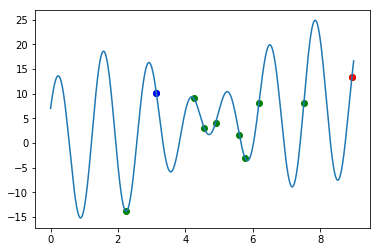

In [41]:
POP = population(10)
for ind in POP.pop:
    print("x = %f, f(x) = %f， prob = %f"%(ind.x,ind.fitness,np.exp(ind.fitness)/POP.roulette))
x = np.linspace(0, 9, 10000)
y = fitness(x)
scatter_x = np.array([ind.x for ind in POP.pop])
scatter_y = np.array([ind.fitness for ind in POP.pop])
a, b = POP.selection()
print(a, b)
selected_ax = POP.pop[a].x
selected_ay = POP.pop[a].fitness
selected_bx = POP.pop[b].x
selected_by = POP.pop[b].fitness
plt.plot(x, y)
plt.scatter(scatter_x, scatter_y, c='g')
plt.scatter(selected_ax, selected_ay, c='r')
plt.scatter(selected_bx, selected_by, c='b')
plt.show()

ind_num = 30, iter_num = 2000, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 1.573152, f(x) = 18.572148
x = 1.573037, f(x) = 18.572128
x = 1.573037, f(x) = 18.572128
x = 1.572933, f(x) = 18.572107
x = 1.572450, f(x) = 18.571955
x = 1.572405, f(x) = 18.571937
x = 1.572009, f(x) = 18.571743
x = 1.571997, f(x) = 18.571736
x = 1.571997, f(x) = 18.571736
x = 1.571997, f(x) = 18.571736
x = 1.571997, f(x) = 18.571736
x = 2.927412, f(x) = 16.288175
x = 4.138610, f(x) = 9.1

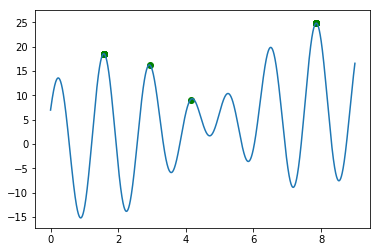

In [34]:
idn = setting['ind_num']
itn = setting['iter_num']
cr = setting['crossover_ratio']
mr = setting['mutation_ratio']

print("ind_num = %d, iter_num = %d, crossover_ratio = %.2f, mutation_ratio = %.2f" %(idn,itn,cr,mr))
pop = evolve(idn, itn, cr, mr)
for ind in pop:
    print("x = %f, f(x) = %f"%(ind.x,ind.fitness))
x = np.linspace(0, 9, 10000)
y = fitness(x)
scatter_x = np.array([ind.x for ind in pop])
scatter_y = np.array([ind.fitness for ind in pop])
plt.plot(x, y)
plt.scatter(scatter_x, scatter_y, c='g')
plt.show()

ind_num = 5, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 6.506816, f(x) = 19.880998
x = 6.506816, f(x) = 19.880998
x = 6.506816, f(x) = 19.880998
x = 6.506816, f(x) = 19.880998
x = 1.523949, f(x) = 18.128332


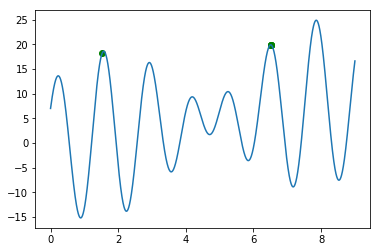

ind_num = 5, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 6.509086, f(x) = 19.882575
x = 6.509086, f(x) = 19.882575
x = 3.057577, f(x) = 13.744322
x = 0.555514, f(x) = -0.127479
x = 3.721414, f(x) = -3.443468


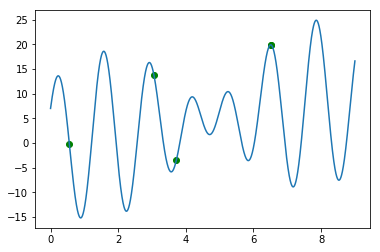

ind_num = 5, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.708698, f(x) = 21.035157
x = 7.708683, f(x) = 21.034423
x = 6.519863, f(x) = 19.869266
x = 1.471879, f(x) = 16.732706
x = 1.333740, f(x) = 9.175958


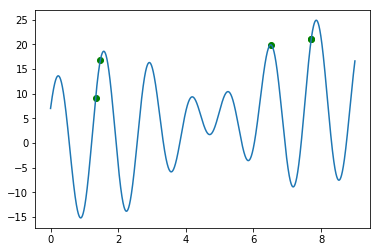

ind_num = 5, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.741924, f(x) = 22.521468
x = 2.912126, f(x) = 16.281453
x = 2.912126, f(x) = 16.281453
x = 2.912126, f(x) = 16.281453
x = 0.107623, f(x) = 11.594145


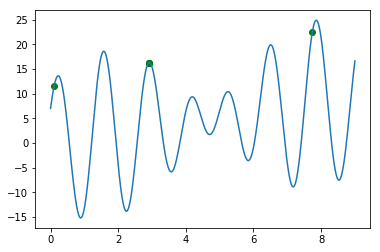

ind_num = 5, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.859383, f(x) = 24.854103
x = 7.859383, f(x) = 24.854103
x = 7.555601, f(x) = 10.922416
x = 1.890898, f(x) = 3.598105
x = 6.027658, f(x) = 0.105258


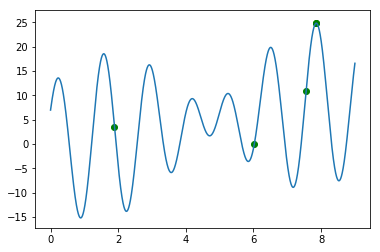

ind_num = 5, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 1.609146, f(x) = 18.343675
x = 6.398014, f(x) = 18.103682
x = 1.500548, f(x) = 17.615484
x = 1.657776, f(x) = 17.307494
x = 8.830071, f(x) = 5.442229


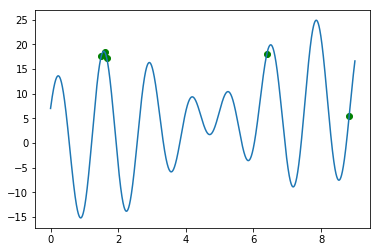

ind_num = 5, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 2.920602, f(x) = 16.293678
x = 2.920602, f(x) = 16.293678
x = 2.920602, f(x) = 16.293678
x = 2.920602, f(x) = 16.293678
x = 2.920602, f(x) = 16.293678


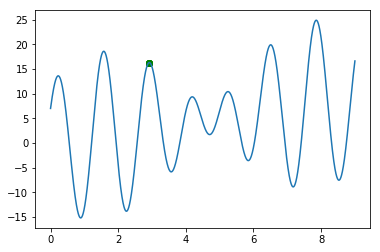

ind_num = 5, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 6.451492, f(x) = 19.380850
x = 1.577537, f(x) = 18.569313
x = 6.375888, f(x) = 17.371062
x = 1.777755, f(x) = 11.620092
x = 6.011251, f(x) = -0.515287


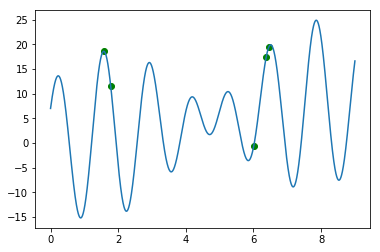

ind_num = 5, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 2.936689, f(x) = 16.258848
x = 2.938254, f(x) = 16.251436
x = 2.949661, f(x) = 16.176055
x = 2.950872, f(x) = 16.165866
x = 0.307879, f(x) = 12.632616


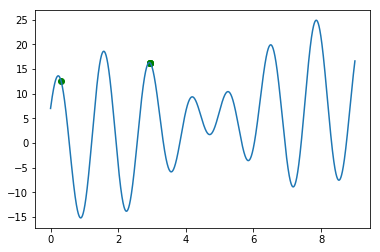

ind_num = 5, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.837621, f(x) = 24.789199
x = 7.837621, f(x) = 24.789199
x = 7.837616, f(x) = 24.789165
x = 1.577219, f(x) = 18.569753
x = 1.562778, f(x) = 18.551141


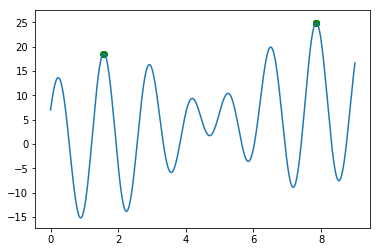

ind_num = 5, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.862467, f(x) = 24.849437
x = 1.460539, f(x) = 16.309250
x = 7.598062, f(x) = 14.110674
x = 1.794167, f(x) = 10.566204
x = 5.131512, f(x) = 9.403576


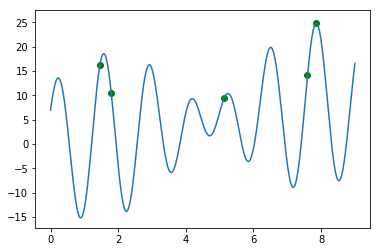

ind_num = 5, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.835442, f(x) = 24.773270
x = 7.834288, f(x) = 24.764137
x = 7.822634, f(x) = 24.645094
x = 7.721673, f(x) = 21.654487
x = 7.601192, f(x) = 14.337900


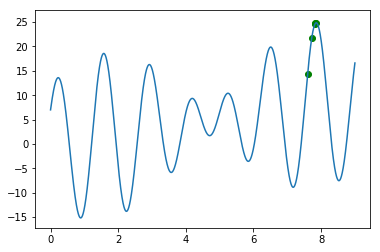

ind_num = 5, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 1.572914, f(x) = 18.572102
x = 1.572914, f(x) = 18.572102
x = 1.572914, f(x) = 18.572102
x = 2.921262, f(x) = 16.293741
x = 2.921836, f(x) = 16.293691


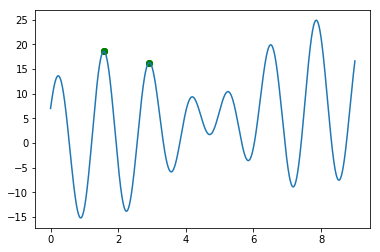

ind_num = 5, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 6.479639, f(x) = 19.744911
x = 2.929243, f(x) = 16.284376
x = 2.929243, f(x) = 16.284376
x = 2.929246, f(x) = 16.284369
x = 3.214015, f(x) = 6.379838


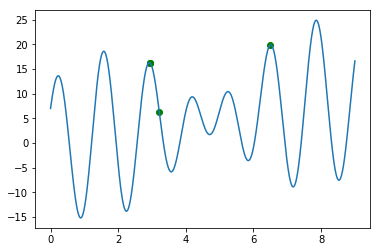

ind_num = 5, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.839724, f(x) = 24.802946
x = 7.839640, f(x) = 24.802426
x = 7.828870, f(x) = 24.714865
x = 7.369174, f(x) = -2.686094
x = 7.109047, f(x) = -8.147162


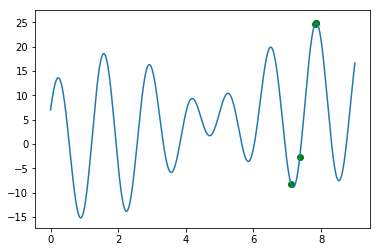

ind_num = 5, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.916259, f(x) = 24.219273
x = 7.916260, f(x) = 24.219261
x = 7.916260, f(x) = 24.219261
x = 7.916260, f(x) = 24.219256
x = 1.655302, f(x) = 17.379750


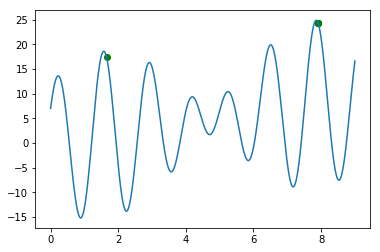

ind_num = 5, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856111, f(x) = 24.855290
x = 7.856111, f(x) = 24.855290
x = 4.528483, f(x) = 3.656431
x = 4.661666, f(x) = 1.837966
x = 5.921933, f(x) = -2.923940


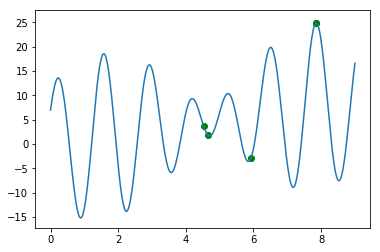

ind_num = 5, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.846000, f(x) = 24.834470
x = 1.561999, f(x) = 18.547992
x = 1.524237, f(x) = 18.133438
x = 1.449820, f(x) = 15.871797
x = 7.589580, f(x) = 13.488623


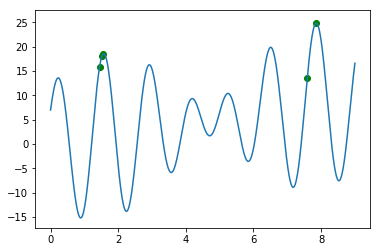

ind_num = 5, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 6.520466, f(x) = 19.867504
x = 2.938399, f(x) = 16.250714
x = 2.938399, f(x) = 16.250714
x = 2.938399, f(x) = 16.250714
x = 3.236716, f(x) = 5.157214


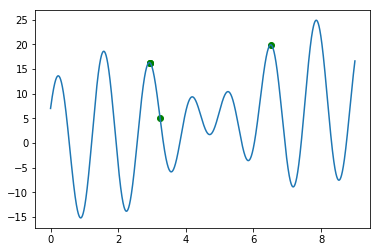

ind_num = 5, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.855239, f(x) = 24.854953
x = 2.732677, f(x) = 11.177431
x = 5.245000, f(x) = 10.405479
x = 1.242851, f(x) = 2.346972
x = 7.428046, f(x) = 1.197785


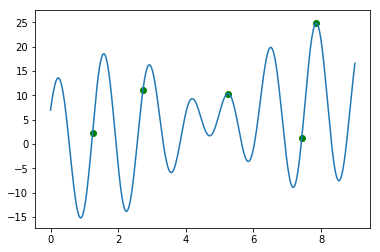

ind_num = 5, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.942943, f(x) = 23.531362
x = 6.593785, f(x) = 18.849895
x = 3.095984, f(x) = 12.240558
x = 3.828167, f(x) = 0.239779
x = 8.475885, f(x) = -7.074652


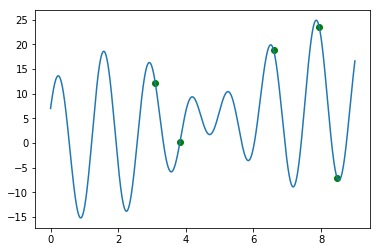

ind_num = 5, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.871036, f(x) = 24.818422
x = 7.764054, f(x) = 23.322076
x = 1.574132, f(x) = 18.572118
x = 1.574132, f(x) = 18.572118
x = 2.938522, f(x) = 16.250095


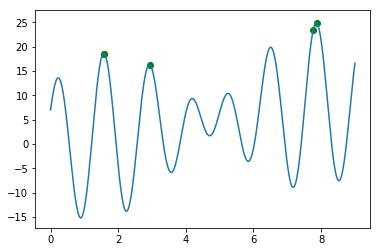

ind_num = 5, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856745, f(x) = 24.855363
x = 1.633282, f(x) = 17.931671
x = 1.314529, f(x) = 7.802159


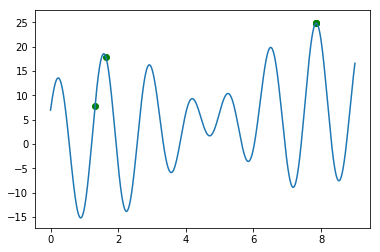

ind_num = 5, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.858678, f(x) = 24.854686
x = 7.854228, f(x) = 24.854217
x = 7.861373, f(x) = 24.851486
x = 2.933359, f(x) = 16.272260
x = 2.248835, f(x) = -13.808142


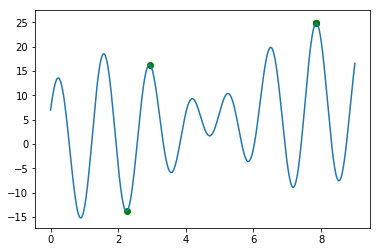

ind_num = 5, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.854237, f(x) = 24.854225
x = 7.854237, f(x) = 24.854225
x = 7.854237, f(x) = 24.854225
x = 7.854237, f(x) = 24.854225
x = 1.569503, f(x) = 18.569200


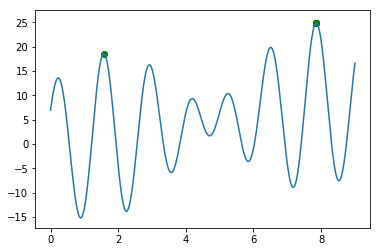

ind_num = 5, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 1.553497, f(x) = 18.499360
x = 1.553496, f(x) = 18.499355
x = 1.540379, f(x) = 18.373208
x = 1.669797, f(x) = 16.927743
x = 7.521560, f(x) = 8.281166


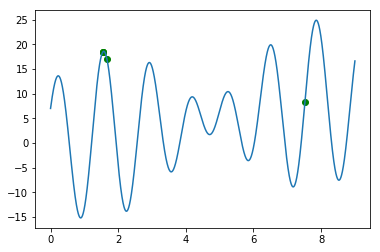

ind_num = 5, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 1.587134, f(x) = 18.538844
x = 1.559495, f(x) = 18.536384
x = 1.592385, f(x) = 18.508100
x = 8.927121, f(x) = 12.152043
x = 1.913747, f(x) = 1.862919


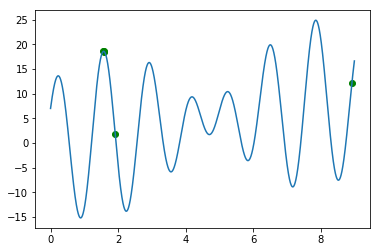

ind_num = 10, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 6.543032, f(x) = 19.723801
x = 6.556127, f(x) = 19.570941
x = 1.573520, f(x) = 18.572177
x = 1.573520, f(x) = 18.572177
x = 1.573512, f(x) = 18.572177
x = 1.573511, f(x) = 18.572177
x = 1.573505, f(x) = 18.572177
x = 1.573503, f(x) = 18.572177
x = 3.010411, f(x) = 15.167441
x = 5.246630, f(x) = 10.405745


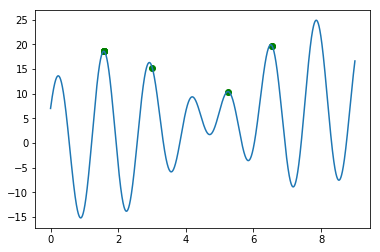

ind_num = 10, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.828849, f(x) = 24.714655
x = 7.707997, f(x) = 21.000321
x = 1.561070, f(x) = 18.543951
x = 1.547102, f(x) = 18.445586
x = 1.547057, f(x) = 18.445158
x = 1.506053, f(x) = 17.753226
x = 7.597782, f(x) = 14.090283
x = 4.141972, f(x) = 9.158357
x = 5.669665, f(x) = -0.479358
x = 3.800288, f(x) = -0.806784


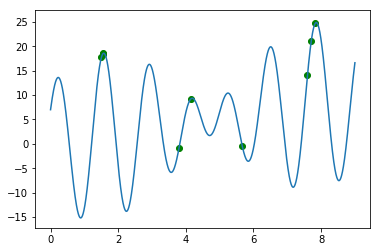

ind_num = 10, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.856772, f(x) = 24.855363
x = 7.857219, f(x) = 24.855322
x = 7.857500, f(x) = 24.855259
x = 7.843548, f(x) = 24.823848
x = 1.625389, f(x) = 18.088911
x = 1.502188, f(x) = 17.657588
x = 0.329912, f(x) = 12.038531
x = 3.132426, f(x) = 10.585872
x = 5.751442, f(x) = -2.587438
x = 3.708070, f(x) = -3.818249


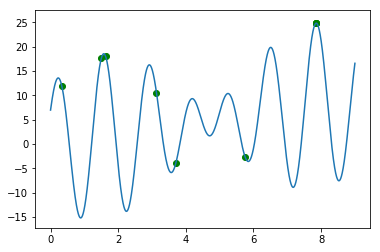

ind_num = 10, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 6.510303, f(x) = 19.882794
x = 6.510303, f(x) = 19.882794
x = 6.510303, f(x) = 19.882794
x = 6.510303, f(x) = 19.882794
x = 6.510303, f(x) = 19.882794
x = 6.510303, f(x) = 19.882794
x = 1.658095, f(x) = 17.298022
x = 1.658095, f(x) = 17.298022
x = 2.871382, f(x) = 15.925016
x = 3.793923, f(x) = -1.039962


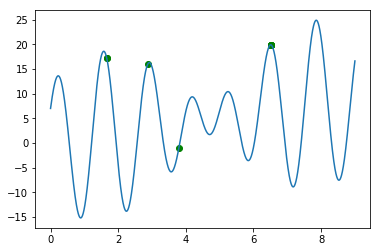

ind_num = 10, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856737, f(x) = 24.855363
x = 7.856737, f(x) = 24.855363
x = 7.856737, f(x) = 24.855363
x = 7.856737, f(x) = 24.855363
x = 1.704537, f(x) = 15.572797
x = 1.708632, f(x) = 15.389056
x = 2.677595, f(x) = 8.030607
x = 6.186514, f(x) = 8.022101
x = 1.904780, f(x) = 2.544114
x = 3.384321, f(x) = -2.032824


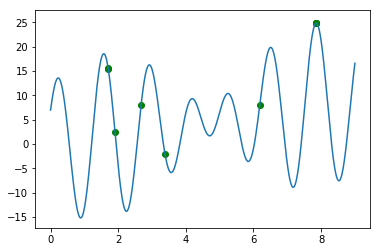

ind_num = 10, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 6.518476, f(x) = 19.872908
x = 6.518828, f(x) = 19.872038
x = 1.573781, f(x) = 18.572169
x = 1.467090, f(x) = 16.558872
x = 2.944789, f(x) = 16.212824
x = 2.876203, f(x) = 15.992943
x = 7.582735, f(x) = 12.980383
x = 1.765314, f(x) = 12.382813
x = 5.259244, f(x) = 10.393124
x = 8.340566, f(x) = -1.819153


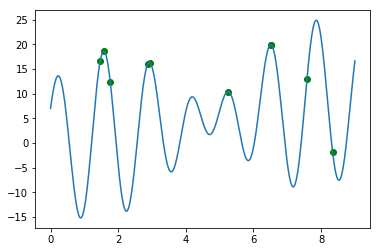

ind_num = 10, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.811751, f(x) = 24.490019
x = 7.811751, f(x) = 24.490019
x = 7.811751, f(x) = 24.490019
x = 7.811728, f(x) = 24.489640
x = 7.811626, f(x) = 24.487986
x = 6.493675, f(x) = 19.842083
x = 1.645435, f(x) = 17.647460
x = 1.645435, f(x) = 17.647460
x = 1.645435, f(x) = 17.647460
x = 1.645435, f(x) = 17.647460


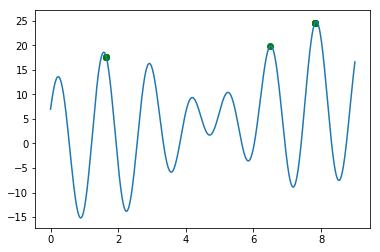

ind_num = 10, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856747, f(x) = 24.855363
x = 7.856748, f(x) = 24.855363
x = 1.600093, f(x) = 18.444990
x = 2.822264, f(x) = 14.843925
x = 0.342755, f(x) = 11.629880
x = 1.354211, f(x) = 10.574961
x = 1.299348, f(x) = 6.682173
x = 5.514767, f(x) = 4.976898
x = 5.602320, f(x) = 1.802594


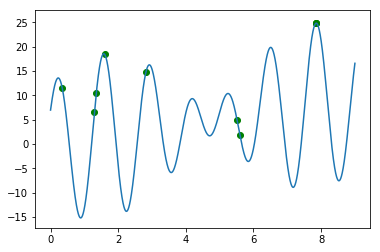

ind_num = 10, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.857033, f(x) = 24.855348
x = 7.854976, f(x) = 24.854797
x = 7.853466, f(x) = 24.853418
x = 7.843293, f(x) = 24.822617
x = 1.510523, f(x) = 17.857374
x = 1.759719, f(x) = 12.714867
x = 1.785182, f(x) = 11.149588
x = 6.188332, f(x) = 8.123670
x = 3.428546, f(x) = -3.605714
x = 2.504986, f(x) = -3.705715


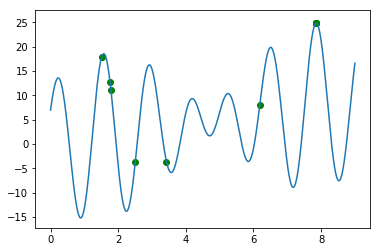

ind_num = 10, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.746859, f(x) = 22.713590
x = 7.746859, f(x) = 22.713590
x = 7.746859, f(x) = 22.713590
x = 6.510439, f(x) = 19.882791
x = 6.510439, f(x) = 19.882791
x = 6.510439, f(x) = 19.882791
x = 6.510439, f(x) = 19.882791
x = 1.563324, f(x) = 18.553218
x = 2.973157, f(x) = 15.904558
x = 2.974603, f(x) = 15.882829


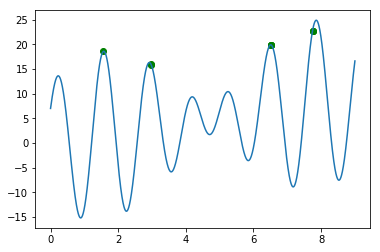

ind_num = 10, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.856717, f(x) = 24.855363
x = 7.856516, f(x) = 24.855353
x = 7.844054, f(x) = 24.826218
x = 7.834081, f(x) = 24.762448
x = 7.809711, f(x) = 24.456264
x = 1.574485, f(x) = 18.572022
x = 1.574487, f(x) = 18.572022
x = 1.574507, f(x) = 18.572015
x = 2.981549, f(x) = 15.770565
x = 4.101200, f(x) = 8.696412


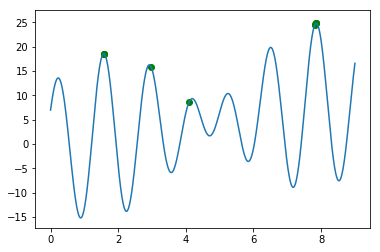

ind_num = 10, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.863458, f(x) = 24.847207
x = 7.863639, f(x) = 24.846760
x = 7.875767, f(x) = 24.789937
x = 1.650163, f(x) = 17.523260
x = 3.060339, f(x) = 13.645715
x = 8.124000, f(x) = 13.612018
x = 0.262930, f(x) = 13.409209
x = 0.304108, f(x) = 12.720446
x = 3.128639, f(x) = 10.766466
x = 6.783009, f(x) = 9.866221


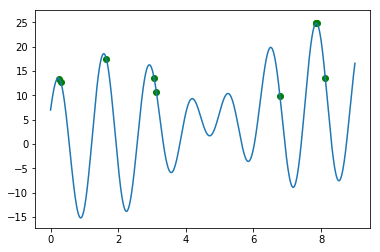

ind_num = 10, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.857271, f(x) = 24.855313
x = 7.857271, f(x) = 24.855313
x = 7.857271, f(x) = 24.855313
x = 7.857271, f(x) = 24.855313
x = 1.573280, f(x) = 18.572163
x = 1.572646, f(x) = 18.572027
x = 2.918767, f(x) = 16.292829
x = 2.918758, f(x) = 16.292823
x = 2.918751, f(x) = 16.292817
x = 5.664788, f(x) = -0.326479


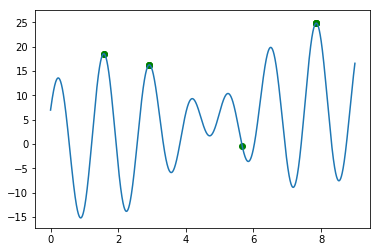

ind_num = 10, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.848327, f(x) = 24.842541
x = 7.848327, f(x) = 24.842540
x = 7.848327, f(x) = 24.842539
x = 7.848274, f(x) = 24.842378
x = 1.575461, f(x) = 18.571522
x = 1.575466, f(x) = 18.571519
x = 1.575600, f(x) = 18.571423
x = 2.950357, f(x) = 16.170249
x = 1.702448, f(x) = 15.664651
x = 7.494424, f(x) = 6.169183


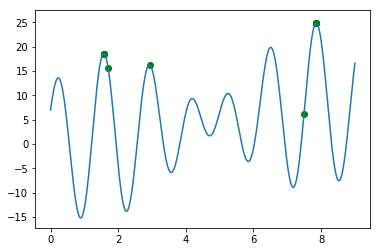

ind_num = 10, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.674343, f(x) = 19.173917
x = 1.572962, f(x) = 18.572113
x = 2.934957, f(x) = 16.266225
x = 2.935071, f(x) = 16.265769
x = 2.987925, f(x) = 15.656088
x = 5.090292, f(x) = 8.637832
x = 0.525945, f(x) = 1.867295
x = 1.231892, f(x) = 1.492431
x = 5.792265, f(x) = -3.229854
x = 2.174956, f(x) = -12.991890


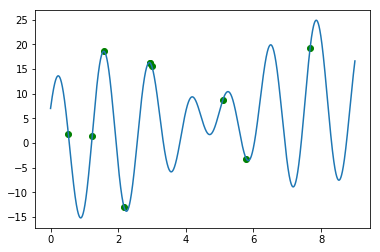

ind_num = 10, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 7.856779, f(x) = 24.855363
x = 0.118025, f(x) = 11.916995
x = 0.374570, f(x) = 10.428997


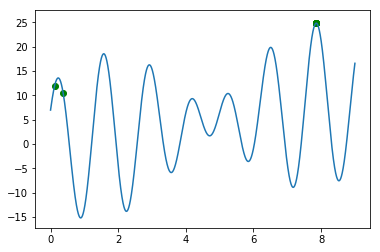

ind_num = 10, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.858091, f(x) = 24.855034
x = 7.858556, f(x) = 24.854769
x = 7.858570, f(x) = 24.854759
x = 7.854498, f(x) = 24.854450
x = 7.853059, f(x) = 24.852905
x = 1.573628, f(x) = 18.572177
x = 4.282037, f(x) = 8.720033
x = 3.946504, f(x) = 4.694053
x = 2.580106, f(x) = 1.484723
x = 7.403600, f(x) = -0.493799


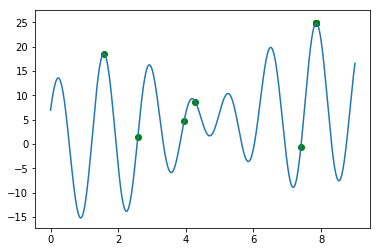

ind_num = 10, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 6.449476, f(x) = 19.346298
x = 6.423206, f(x) = 18.796657
x = 6.632028, f(x) = 17.703726
x = 2.935879, f(x) = 16.262408
x = 2.935896, f(x) = 16.262336
x = 1.705151, f(x) = 15.545591
x = 8.848411, f(x) = 6.724457
x = 6.133932, f(x) = 5.134040
x = 0.486606, f(x) = 4.426028
x = 3.337970, f(x) = -0.028284


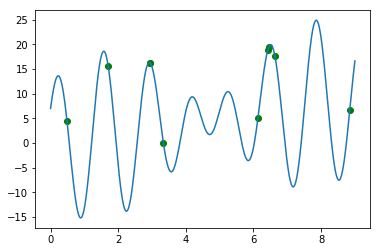

ind_num = 10, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.858256, f(x) = 24.854949
x = 7.858256, f(x) = 24.854949
x = 7.858256, f(x) = 24.854949
x = 7.858256, f(x) = 24.854949
x = 2.950099, f(x) = 16.172416
x = 2.950099, f(x) = 16.172416
x = 2.950099, f(x) = 16.172416
x = 2.950099, f(x) = 16.172416
x = 2.950099, f(x) = 16.172416
x = 2.950099, f(x) = 16.172416


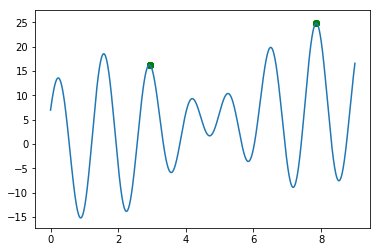

ind_num = 10, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.856664, f(x) = 24.855362
x = 7.856664, f(x) = 24.855362
x = 7.856664, f(x) = 24.855362
x = 7.856664, f(x) = 24.855362
x = 7.856664, f(x) = 24.855362
x = 1.777026, f(x) = 11.665659
x = 2.702206, f(x) = 9.505537
x = 4.903472, f(x) = 4.183676
x = 1.905842, f(x) = 2.463452
x = 6.019086, f(x) = -0.225230


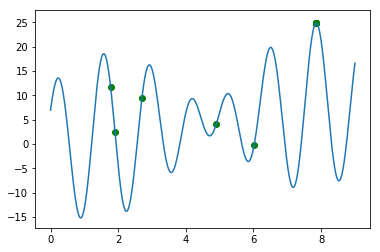

ind_num = 10, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.734017, f(x) = 22.197777
x = 6.509616, f(x) = 19.882724
x = 3.020699, f(x) = 14.901316
x = 5.195727, f(x) = 10.198713
x = 3.148224, f(x) = 9.814256
x = 1.251865, f(x) = 3.048964
x = 5.652111, f(x) = 0.081759
x = 3.739666, f(x) = -2.892008
x = 8.682191, f(x) = -3.623042
x = 7.003691, f(x) = -4.209701


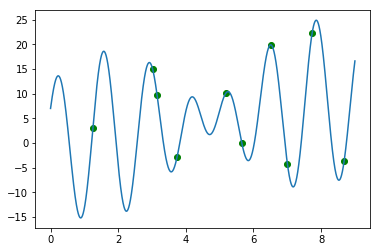

ind_num = 10, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 2.921267, f(x) = 16.293741
x = 2.921163, f(x) = 16.293740


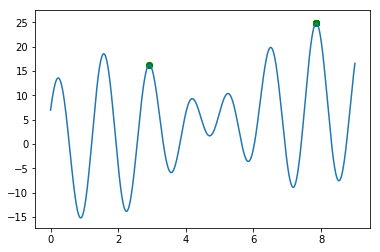

ind_num = 10, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856742, f(x) = 24.855363
x = 1.536868, f(x) = 18.328956
x = 1.512344, f(x) = 17.897828
x = 1.669165, f(x) = 16.948873
x = 1.670311, f(x) = 16.910452
x = 2.931237, f(x) = 16.279125
x = 1.819008, f(x) = 8.881087


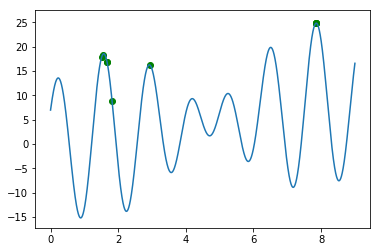

ind_num = 10, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.829875, f(x) = 24.724807
x = 7.829133, f(x) = 24.717506
x = 7.828952, f(x) = 24.715688
x = 7.925186, f(x) = 24.016097
x = 7.653650, f(x) = 17.913002
x = 2.885403, f(x) = 16.103417
x = 2.768654, f(x) = 12.892603
x = 3.275787, f(x) = 3.073852
x = 0.538190, f(x) = 1.045943
x = 7.242732, f(x) = -8.090093


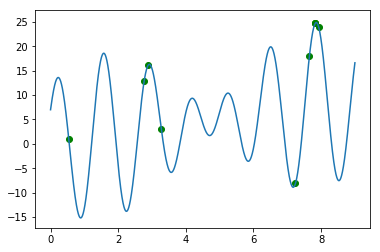

ind_num = 10, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.795311, f(x) = 24.176226
x = 7.795311, f(x) = 24.176226
x = 7.795311, f(x) = 24.176226
x = 7.795311, f(x) = 24.176226
x = 7.795311, f(x) = 24.176226
x = 6.560368, f(x) = 19.510525
x = 1.570832, f(x) = 18.570832
x = 1.578046, f(x) = 18.568533
x = 2.918325, f(x) = 16.292476
x = 1.887176, f(x) = 3.880074


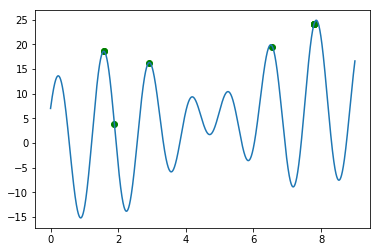

ind_num = 10, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856696, f(x) = 24.855362
x = 7.856673, f(x) = 24.855362
x = 7.856492, f(x) = 24.855351
x = 7.864626, f(x) = 24.844123
x = 1.550795, f(x) = 18.478441
x = 1.655141, f(x) = 17.384383
x = 2.927238, f(x) = 16.288484
x = 2.927243, f(x) = 16.288475
x = 2.927263, f(x) = 16.288440
x = 7.596908, f(x) = 14.026561


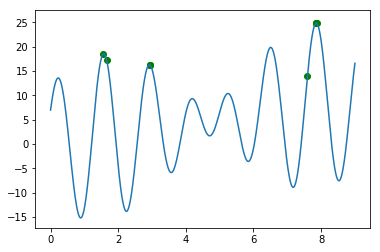

ind_num = 10, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.835870, f(x) = 24.776536
x = 7.921675, f(x) = 24.099283
x = 7.747341, f(x) = 22.731943
x = 7.743246, f(x) = 22.573661
x = 7.707709, f(x) = 20.985976
x = 1.598861, f(x) = 18.456505
x = 2.860783, f(x) = 15.751441
x = 4.173027, f(x) = 9.325039
x = 8.240884, f(x) = 4.845680
x = 1.263047, f(x) = 3.916601


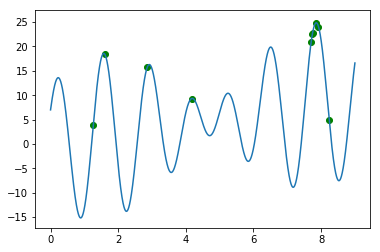

ind_num = 30, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.856749, f(x) = 24.855363
x = 7.856749, f(x) = 24.855363
x = 7.856753, f(x) = 24.855363
x = 7.856760, f(x) = 24.855363
x = 7.856711, f(x) = 24.855363
x = 7.856708, f(x) = 24.855363
x = 7.856701, f(x) = 24.855363
x = 7.856675, f(x) = 24.855362
x = 7.856675, f(x) = 24.855362
x = 7.856663, f(x) = 24.855362
x = 7.856633, f(x) = 24.855361
x = 7.856607, f(x) = 24.855359
x = 1.573255, f(x) = 18.572161
x = 1.573183, f(x) = 18.572152
x = 1.573106, f(x) = 18.572140
x = 1.572907, f(x) = 18.572101
x = 1.572874, f(x) = 18.572093
x = 1.572860, f(x) = 18.572089
x = 1.572826, f(x) = 18.572080
x = 1.572524, f(x) = 18.571984
x = 1.574634, f(x) = 18.571969
x = 1.572396, f(x) = 18.571933
x = 1.572312, f(x) = 18.571896
x = 1.572308, f(x) = 18.571894
x = 1.569545, f(x) = 18.569262
x = 1.659408, f(x) = 17.258719
x = 2.980423, f(x) = 15.789664
x = 7.550631, f(x) = 10.539671
x = 4.204491, f(x) = 9.333330
x = 6.943253, f(x) = -0.77

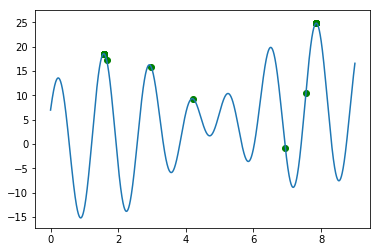

ind_num = 30, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.856700, f(x) = 24.855363
x = 7.856692, f(x) = 24.855362
x = 7.856691, f(x) = 24.855362
x = 7.856675, f(x) = 24.855362
x = 7.856658, f(x) = 24.855362
x = 7.856655, f(x) = 24.855361
x = 7.856651, f(x) = 24.855361
x = 7.860023, f(x) = 24.853417
x = 7.864109, f(x) = 24.845549
x = 7.828821, f(x) = 24.714368
x = 7.721441, f(x) = 21.643843
x = 1.571676, f(x) = 18.571536
x = 1.578008, f(x) = 18.568595
x = 1.578035, f(x) = 18.568552
x = 1.578391, f(x) = 18.567953
x = 1.578839, f(x) = 18.567132
x = 1.579130, f(x) = 18.566561
x = 1.579283, f(x) = 18.566249
x = 1.588359, f(x) = 18.532561
x = 1.546313, f(x) = 18.437934
x = 1.455657, f(x) = 16.114411
x = 5.340490, f(x) = 9.680946
x = 3.174089, f(x) = 8.497346
x = 6.189336, f(x) = 8.179716
x = 3.188053, f(x) = 7.765333
x = 7.509297, f(x) = 7.325106
x = 4.790356, f(x) = 2.202971
x = 3.292906, f(x) = 2.185144
x = 7.022484, f(x) = -5.127411
x = 1.077318, f(x) = -9.480731


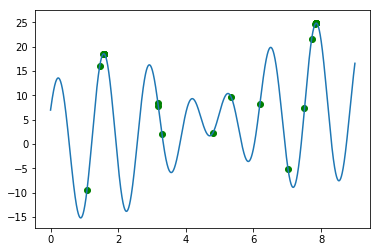

ind_num = 30, iter_num = 500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.856739, f(x) = 24.855363
x = 7.856737, f(x) = 24.855363
x = 7.856726, f(x) = 24.855363
x = 7.856721, f(x) = 24.855363
x = 7.856662, f(x) = 24.855362
x = 7.856656, f(x) = 24.855361
x = 7.856537, f(x) = 24.855355
x = 7.854800, f(x) = 24.854679
x = 7.849813, f(x) = 24.846667
x = 7.842717, f(x) = 24.819756
x = 1.579180, f(x) = 18.566461
x = 2.928669, f(x) = 16.285672
x = 2.940836, f(x) = 16.237652
x = 8.092283, f(x) = 15.848409
x = 2.840575, f(x) = 15.328930
x = 0.193453, f(x) = 13.433577
x = 0.112051, f(x) = 11.734662
x = 0.341514, f(x) = 11.671316
x = 1.347602, f(x) = 10.131398
x = 3.142818, f(x) = 10.081447
x = 3.145635, f(x) = 9.942613
x = 4.168523, f(x) = 9.310743
x = 5.018399, f(x) = 6.989987
x = 4.543385, f(x) = 3.366714
x = 3.895766, f(x) = 2.835872
x = 6.044226, f(x) = 0.781274
x = 3.837165, f(x) = 0.583841
x = 7.031610, f(x) = -5.542802
x = 3.582417, f(x) = -5.817421
x = 2.370349, f(x) = -11.171771


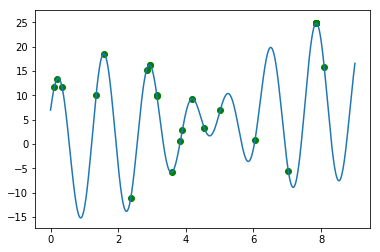

ind_num = 30, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.856748, f(x) = 24.855363
x = 7.856709, f(x) = 24.855363
x = 7.856796, f(x) = 24.855362
x = 7.856805, f(x) = 24.855362
x = 7.856661, f(x) = 24.855362
x = 7.856656, f(x) = 24.855361
x = 7.856625, f(x) = 24.855360
x = 7.856284, f(x) = 24.855325
x = 7.857765, f(x) = 24.855174
x = 7.858133, f(x) = 24.855014
x = 7.859557, f(x) = 24.853931
x = 7.860218, f(x) = 24.853179
x = 7.860231, f(x) = 24.853163
x = 7.860285, f(x) = 24.853094
x = 7.861073, f(x) = 24.851972
x = 1.606885, f(x) = 18.371724
x = 1.606944, f(x) = 18.371011
x = 1.606951, f(x) = 18.370927
x = 1.607069, f(x) = 18.369506
x = 1.607231, f(x) = 18.367548
x = 1.607289, f(x) = 18.366848
x = 1.628806, f(x) = 18.023501
x = 1.628813, f(x) = 18.023374
x = 1.483401, f(x) = 17.120371
x = 2.937373, f(x) = 16.255696
x = 2.937422, f(x) = 16.255465
x = 2.937463, f(x) = 16.255271
x = 1.720639, f(x) = 14.822745
x = 5.628182, f(x) = 0.889215
x = 5.642532, f(x) = 0.399

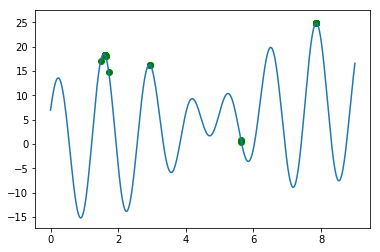

ind_num = 30, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856681, f(x) = 24.855362
x = 7.856634, f(x) = 24.855361
x = 6.576840, f(x) = 19.225599
x = 1.575395, f(x) = 18.571568
x = 1.575506, f(x) = 18.571491
x = 1.575981, f(x) = 18.571116
x = 1.576771, f(x) = 18.570311
x = 1.576895, f(x) = 18.570163
x = 1.576989, f(x) = 18.570049
x = 1.536590, f(x) = 18.325262
x = 1.642661, f(x) = 17.716790
x = 1.675204, f(x) = 16.741626
x = 1.677088, f(x) = 16.674571
x = 2.873495, f(x) = 15.955636
x = 1.695922, f(x) = 15.943261
x = 2.872079, f(x) = 15.935257
x = 4.175564, f(x) = 9.331631
x = 4.259436, f(x) = 8.984547
x = 4.118880, f(x) = 8.930527
x = 4.286871, f(x) = 8.655242
x = 5.631878, f(x) = 0.761788
x = 6.002745, f(x) = -0.816791
x = 8.363480, f(x) = -3.075740
x = 5.884392, f(x) = -3.404146

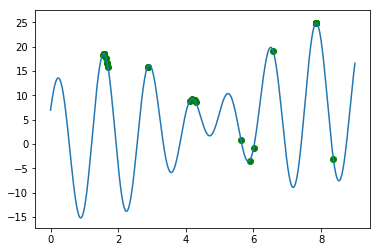

ind_num = 30, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.856754, f(x) = 24.855363
x = 7.856754, f(x) = 24.855363
x = 7.856758, f(x) = 24.855363
x = 7.856711, f(x) = 24.855363
x = 7.856541, f(x) = 24.855355
x = 7.857192, f(x) = 24.855327
x = 7.857534, f(x) = 24.855250
x = 7.855556, f(x) = 24.855107
x = 7.855556, f(x) = 24.855107
x = 7.855505, f(x) = 24.855085
x = 7.840551, f(x) = 24.807915
x = 1.473334, f(x) = 16.784057
x = 2.976904, f(x) = 15.847095
x = 1.445348, f(x) = 15.678907
x = 1.433397, f(x) = 15.134091
x = 2.741597, f(x) = 11.630404
x = 1.338206, f(x) = 9.487368
x = 8.877386, f(x) = 8.753943
x = 6.166824, f(x) = 6.926823
x = 3.247745, f(x) = 4.564226
x = 1.264452, f(x) = 4.025225
x = 8.253613, f(x) = 3.914840
x = 4.566447, f(x) = 2.953512
x = 3.884686, f(x) = 2.413569
x = 1.232922, f(x) = 1.572778
x = 0.538582, f(x) = 1.019537
x = 5.701664, f(x) = -1.415387
x = 5.976698, f(x) = -1.649573
x = 5.753760, f(x) = -2.632183
x = 7.276369, f(x) = -7.122186


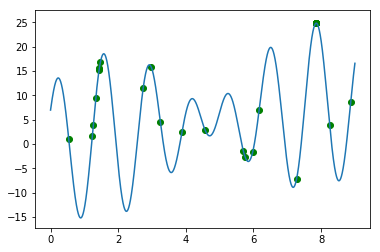

ind_num = 30, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856748, f(x) = 24.855363
x = 1.572284, f(x) = 18.571883
x = 1.567795, f(x) = 18.566165
x = 1.598597, f(x) = 18.458903
x = 1.612567, f(x) = 18.297776
x = 1.612666, f(x) = 18.296387
x = 1.614367, f(x) = 18.271960
x = 1.626845, f(x) = 18.061539
x = 7.646490, f(x) = 17.454910
x = 2.928816, f(x) = 16.285349
x = 2.932094, f(x) = 16.276511
x = 2.909155, f(x) = 16.272141
x = 2.908900, f(x) = 16.271218
x = 2.908632, f(x) = 16.270229
x = 2.903961, f(x) = 16.2

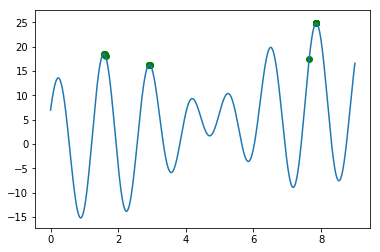

ind_num = 30, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856702, f(x) = 24.855363
x = 7.856642, f(x) = 24.855361
x = 7.856641, f(x) = 24.855361
x = 7.856641, f(x) = 24.855361
x = 7.856641, f(x) = 24.855361
x = 7.856641, f(x) = 24.855361
x = 7.856640, f(x) = 24.855361
x = 7.856616, f(x) = 24.855360
x = 7.857684, f(x) = 24.855203
x = 7.749301, f(x) = 22.805811
x = 1.573550, f(x) = 18.572178
x = 1.573519, f(x) = 18.572177
x = 1.573606, f(x) = 18.572177
x = 1.573425, f(x) = 18.572174
x = 1.573405, f(x) = 18.572173
x = 6.614330, f(x) = 18.284449
x = 2.909024, f(x) = 16.271668
x = 2.938585, f(x) = 16.249779
x = 2.943570, f(x) = 16.220964
x = 2.896031, f(x) = 16.199656
x = 7.626142, f(x) = 16.098061
x = 3.017118, f(x) = 14.996897
x = 6.268273, f(x) = 12.510894
x = 1.800816, f(x) = 10.125113
x = 4.552225, f(x) = 3.202968
x = 3.276329, f(x) = 3.045400
x = 4.598657, f(x) = 2.460473
x = 3.868584, f(x) = 1.794656
x = 0.553736, f(x) = -0.006577
x = 5.786457, f(x) = -3.15799

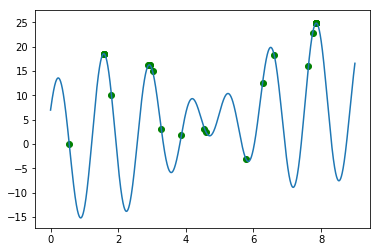

ind_num = 30, iter_num = 500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.856791, f(x) = 24.855362
x = 7.856794, f(x) = 24.855362
x = 7.856835, f(x) = 24.855361
x = 7.856885, f(x) = 24.855359
x = 7.856488, f(x) = 24.855351
x = 7.856442, f(x) = 24.855346
x = 7.856252, f(x) = 24.855319
x = 7.857306, f(x) = 24.855306
x = 7.856002, f(x) = 24.855263
x = 7.865686, f(x) = 24.840898
x = 7.867284, f(x) = 24.835265
x = 7.883138, f(x) = 24.729510
x = 7.826884, f(x) = 24.694155
x = 8.039974, f(x) = 19.169097
x = 1.591230, f(x) = 18.515716
x = 1.518735, f(x) = 18.030616
x = 2.931289, f(x) = 16.278971
x = 2.843674, f(x) = 15.401454
x = 2.833714, f(x) = 15.158450
x = 3.019933, f(x) = 14.922024
x = 3.083849, f(x) = 12.745211
x = 1.787050, f(x) = 11.029554
x = 1.880598, f(x) = 4.377278
x = 2.589079, f(x) = 2.113010
x = 1.222143, f(x) = 0.732908
x = 5.650374, f(x) = 0.138849
x = 6.935571, f(x) = -0.297247
x = 7.376187, f(x) = -2.259749
x = 3.732486, f(x) = -3.113999
x = 5.847859, f(x) = -3.56019

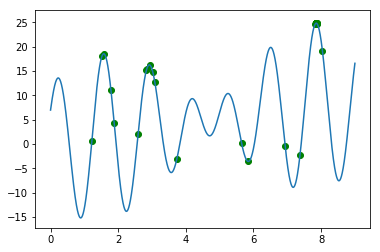

ind_num = 30, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 1.573570, f(x) = 18.572178
x = 1.573546, f(x) = 18.572178
x = 1.573546, f(x) = 18.572178
x = 1.573546, f(x) = 18.572178
x = 1.573573, f(x) = 18.572178
x = 1.573544, f(x) = 18.572178
x = 1.573543, f(x) = 18.572178
x = 1.573543, f(x) = 18.572178
x = 1.573543, f(x) = 18.572178
x = 1.573541, f(x) = 18.572178
x = 1.573577, f(x) = 18.572177
x = 2.921186, f(x) = 16.293740
x = 2.918328, f(x) = 16.292479
x = 2.925904, f(x) = 16.290566
x = 2.933840, f(x) = 16.270521
x = 2.946593, f(x) = 16.200003
x = 6.952845, f(x) = -1.

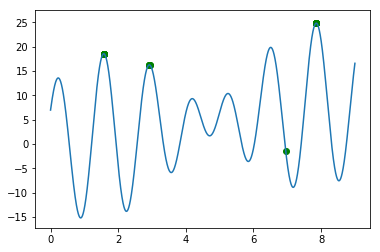

ind_num = 30, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.855619, f(x) = 24.855134
x = 7.853912, f(x) = 24.853911
x = 7.934076, f(x) = 23.786665
x = 7.946091, f(x) = 23.434437
x = 1.577964, f(x) = 18.568665
x = 1.578621, f(x) = 18.567540
x = 1.579900, f(x) = 18.564901
x = 1.583196, f(x) = 18.555376
x = 1.529314, f(x) = 18.218842
x = 1.490503, f(x) = 17.337449
x = 1.485658, f(x) = 17.191191
x = 1.686339, f(x) = 16.329091
x = 2.947283, f(x) = 16.194855
x = 3.072776, f(x) = 13.182572
x = 7.555251, f(x) = 10.895506
x = 7.508670, f(x) = 7.276239
x = 8.815967, f(x) = 4.464627
x = 6.101776, f(x) = 3.461421
x = 8.294006, f(x) = 1.090783
x = 7.420419, f(x) = 0.659535
x = 7.396429, f(x) = -0.970165
x = 2.536420, f(x) = -1.567330
x = 1.067272, f(x) = -10.0508

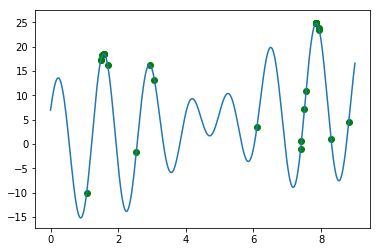

ind_num = 30, iter_num = 1000, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.856617, f(x) = 24.855360
x = 7.861758, f(x) = 24.850815
x = 7.836717, f(x) = 24.782798
x = 1.580943, f(x) = 18.562311
x = 1.581033, f(x) = 18.562071
x = 1.581602, f(x) = 18.560472
x = 6.619151, f(x) = 18.134710
x = 1.661082, f(x) = 17.207797
x = 1.673866, f(x) = 16.788539
x = 2.913753, f(x) = 16.285446
x = 2.905093, f(x) = 16.255171
x = 2.901031, f(x) = 16.233308
x = 3.015832, f(x) = 15.030441
x = 6.295609, f(x) = 13.907774
x = 0.235355, f(x) = 13.589568
x = 0.310895, f(x) = 12.559413
x = 3.107452, f(x) = 11.741046
x = 4.069725, f(x) = 8.154246
x = 3.193137, f(x) = 7.496096
x = 1.846223, f(x) = 6.935284
x = 1.266194, f(x) = 4.159814
x = 3.272716, f(x) = 3.235298
x = 1.917751, f(x) = 1.559003
x = 5.644795, f(x) = 0.323935
x = 5.669664, f(x) = -0.479328
x = 1.192653, f(x) = -1.544955
x = 3.444275, f(x) = -4.072913
x = 8.593609, f(x) = -6.780252
x = 8.564132, f(x) = -7.295724
x = 0.700489, f(x) = -9.430340


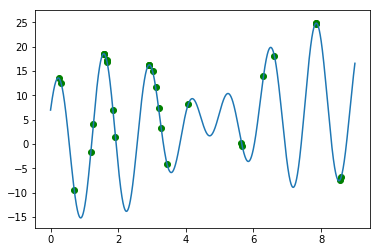

ind_num = 30, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.856120, f(x) = 24.855292
x = 7.855868, f(x) = 24.855224
x = 1.573556, f(x) = 18.572178
x = 1.573556, f(x) = 18.572178
x = 1.573556, f(x) = 18.572178
x = 1.573556, f(x) = 18.572178
x = 1.573555, f(x) = 18.572178
x = 1.573555, f(x) = 18.572178
x = 1.573555, f(x) = 18.572178
x = 1.573555, f(x) = 18.572178
x = 1.573553, f(x) = 18.572178
x = 1.573541, f(x) = 18.572178
x = 1.573685, f(x) = 18.572175
x = 1.591998, f(x) = 18.510703
x = 2.921550, f(x) = 16.293728
x = 2.922981, f(x) = 16.293303
x = 2.925758, f(x) = 16.

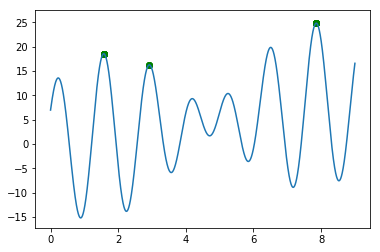

ind_num = 30, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856745, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.856731, f(x) = 24.855363
x = 7.856692, f(x) = 24.855362
x = 7.856407, f(x) = 24.855342
x = 7.855236, f(x) = 24.854951
x = 7.848409, f(x) = 24.842789
x = 1.573567, f(x) = 18.572178
x = 1.573583, f(x) = 18.572177
x = 1.573601, f(x) = 18.572177
x = 1.573613, f(x) = 18.572177
x = 1.573370, f(x) = 18.572171
x = 1.573362, f(x) = 18.572171
x = 1.573904, f(x) = 18.572156
x = 1.574484, f(x) = 18.572023
x = 1.572449, f(x) = 18.571955
x = 1.582307, f(x) = 18.558331
x = 1.440249, f(x) = 15.451608
x = 1.436962, f(x) = 15.300994
x = 1.762613, f(x) = 12.543978
x = 1.788628, f(x) = 10.927599
x = 1.790324, f(x) = 10.817552
x = 5.207857, f(x) = 10.284464
x = 4.186083, f(x) = 9.347782
x = 4.238787, f(x) = 9.166957
x = 3.348543, f(x) = -0.513329
x = 5.936022, f(x) = -2.66

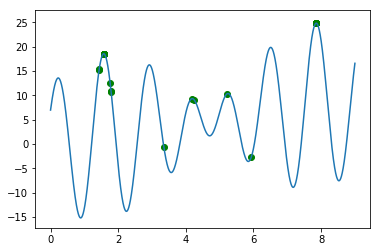

ind_num = 30, iter_num = 1000, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.856740, f(x) = 24.855363
x = 7.856770, f(x) = 24.855363
x = 7.856687, f(x) = 24.855362
x = 7.856546, f(x) = 24.855356
x = 7.857477, f(x) = 24.855266
x = 7.860171, f(x) = 24.853238
x = 7.866534, f(x) = 24.838025
x = 7.846037, f(x) = 24.834613
x = 7.925388, f(x) = 24.011170
x = 7.697619, f(x) = 20.468885
x = 1.560251, f(x) = 18.540129
x = 1.553523, f(x) = 18.499545
x = 1.539149, f(x) = 18.358198
x = 1.520444, f(x) = 18.063703
x = 2.963565, f(x) = 16.034038
x = 1.431062, f(x) = 15.022758
x = 6.198271, f(x) = 8.679027
x = 0.423592, f(x) = 8.100844
x = 1.877899, f(x) = 4.580799
x = 3.868982, f(x) = 1.810001
x = 2.570385, f(x) = 0.803054
x = 3.809538, f(x) = -0.463632
x = 1.130049, f(x) = -6.122248
x = 8.446750, f(x) = -6.418539
x = 8.495512, f(x) = -7.355226
x = 2.104186, f(x) = -10.5250

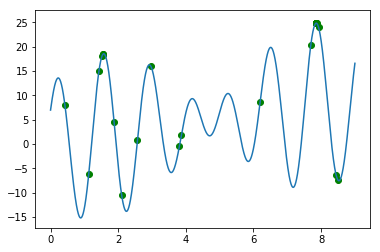

ind_num = 30, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 1.573607, f(x) = 18.572177
x = 1.573608, f(x) = 18.572177
x = 1.573609, f(x) = 18.572177
x = 1.573609, f(x) = 18.572177
x = 1.573609, f(x) = 18.572177
x = 1.573609, f(x) = 18.572177
x = 1.573609, f(x) = 18.572177
x = 1.573610, f(x) = 18.572177
x = 1.573611, f(x) = 18.572177
x = 1.573611, f(x) = 18.572177
x = 1.573620, f(x) = 18.572177
x = 4.198977, f(x) = 9.343293
x = 4.257534, f(x) = 9.003788
x = 4.336745, f(x) = 7.839955
x = 2.544498, f(x) = -1.007

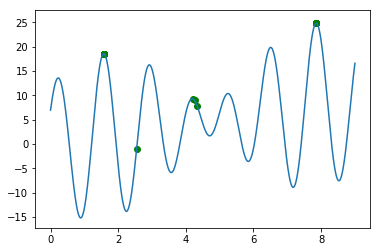

ind_num = 30, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856483, f(x) = 24.855351
x = 7.842676, f(x) = 24.819546
x = 1.585007, f(x) = 18.548469
x = 1.585331, f(x) = 18.547109
x = 1.585347, f(x) = 18.547041
x = 1.587825, f(x) = 18.535365
x = 1.593579, f(x) = 18.499719
x = 2.862394, f(x) = 15.779965
x = 1.434652, f(x) = 15.193252
x = 7.609225, f(x) = 14.914934
x = 0.239140, f(x) = 13.578206
x = 1.387082, f(x) = 12.650142
x = 1.354483, f(x) = 10.593092
x = 4.110613, f(x) = 8.827462
x = 4.109819, f(x) = 8.816968
x = 4.536924, f(x) = 3.490320
x = 4.554181, f(x) = 3.167618
x = 8.749112, f(x) = 0.067312
x = 2.231768, f(x) = -13.7860

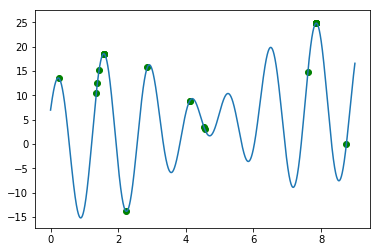

ind_num = 30, iter_num = 1000, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.856726, f(x) = 24.855363
x = 7.856725, f(x) = 24.855363
x = 7.856721, f(x) = 24.855363
x = 7.856718, f(x) = 24.855363
x = 7.856717, f(x) = 24.855363
x = 7.857053, f(x) = 24.855346
x = 7.855271, f(x) = 24.854970
x = 7.846489, f(x) = 24.836328
x = 1.606715, f(x) = 18.373753
x = 1.523001, f(x) = 18.111271
x = 6.657464, f(x) = 16.724362
x = 2.917989, f(x) = 16.292170
x = 2.940284, f(x) = 16.240759
x = 2.990874, f(x) = 15.599467
x = 2.850783, f(x) = 15.557285
x = 7.611891, f(x) = 15.104402
x = 2.773030, f(x) = 13.080120
x = 7.583844, f(x) = 13.063100
x = 5.208472, f(x) = 10.288221
x = 4.144032, f(x) = 9.174371
x = 4.240153, f(x) = 9.156734
x = 4.241759, f(x) = 9.144371
x = 1.828841, f(x) = 8.188584
x = 1.885343, f(x) = 4.018755
x = 8.287904, f(x) = 1.502253
x = 6.909290, f(x) = 1.393523
x = 3.843032, f(x) = 0.809216
x = 8.339340, f(x) = -1.748389
x = 5.773714, f(x) = -2.977062
x = 7.276782, f(x) = -7.108013


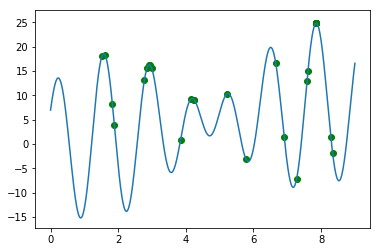

ind_num = 30, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856742, f(x) = 24.855363
x = 1.598428, f(x) = 18.460427
x = 1.602220, f(x) = 18.423821
x = 1.602329, f(x) = 18.422686
x = 1.602349, f(x) = 18.422487
x = 1.602445, f(x) = 18.421481
x = 1.602467, f(x) = 18.421256
x = 1.602618, f(x) = 18.419676
x = 1.602841, f(x) = 18.417331
x = 1.603316, f(x) = 18.412278
x = 1.603541, f(x) = 18.409857
x = 2.932085, f(x) = 16.276539
x = 2.934485, f(x) = 16.268086
x = 4.174108, f(x) = 9.327977
x = 4.243293, f(x) = 9.132217
x = 6.014667, f(x) = -0.39

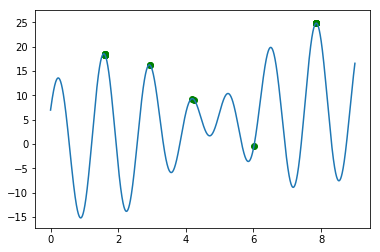

ind_num = 30, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856729, f(x) = 24.855363
x = 7.856498, f(x) = 24.855352
x = 7.863811, f(x) = 24.846325
x = 7.871927, f(x) = 24.813674
x = 7.830737, f(x) = 24.733042
x = 1.545215, f(x) = 18.426916
x = 1.514611, f(x) = 17.946565
x = 1.634673, f(x) = 17.901702
x = 1.503269, f(x) = 17.684852
x = 1.662266, f(x) = 17.171213
x = 2.920293, f(x) = 16.293605
x = 6.680750, f(x) = 15.687493
x = 3.002467, f(x) = 15.354889
x = 6.704891, f(x) = 14.483258
x = 7.586510, f(x) = 13.261321
x = 5.182925, f(x) = 10.084706
x = 4.178181, f(x) = 9.337328
x = 7.449750, f(x) = 2.774028
x = 3.860897, f(x) = 1.498092
x = 3.328855, f(x) = 0.401420
x = 6.025104, f(x) = 0.005383
x = 2.385647, f(x) = -10.5228

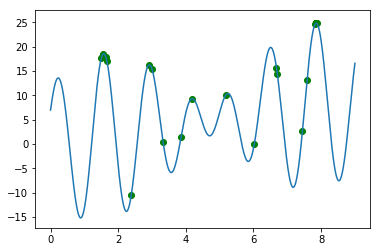

ind_num = 30, iter_num = 1500, crossover_ratio = 0.70, mutation_ratio = 0.30
x = 7.856749, f(x) = 24.855363
x = 7.856622, f(x) = 24.855360
x = 7.855690, f(x) = 24.855162
x = 7.854577, f(x) = 24.854513
x = 7.852932, f(x) = 24.852733
x = 7.822442, f(x) = 24.642718
x = 7.928205, f(x) = 23.941187
x = 7.730821, f(x) = 22.061519
x = 6.552856, f(x) = 19.613896
x = 1.569880, f(x) = 18.569728
x = 1.569627, f(x) = 18.569380
x = 1.568546, f(x) = 18.567630
x = 1.568280, f(x) = 18.567133
x = 1.562335, f(x) = 18.549379
x = 1.667758, f(x) = 16.995494
x = 2.969429, f(x) = 15.957897
x = 1.434959, f(x) = 15.207676
x = 1.731479, f(x) = 14.277255
x = 8.943088, f(x) = 13.195742
x = 1.813875, f(x) = 9.237263
x = 1.820760, f(x) = 8.758687
x = 4.872406, f(x) = 3.520329
x = 4.635161, f(x) = 2.040119
x = 4.737601, f(x) = 1.781387
x = 1.208357, f(x) = -0.337077
x = 3.361800, f(x) = -1.099396
x = 8.454187, f(x) = -6.612830
x = 7.071509, f(x) = -7.101741
x = 2.139838, f(x) = -11.962348
x = 0.980692, f(x) = -13.807

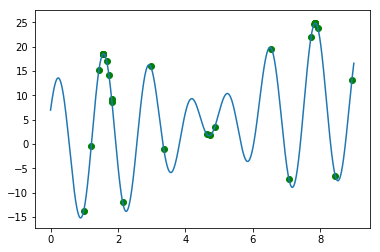

ind_num = 30, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.01
x = 7.857657, f(x) = 24.855212
x = 7.857819, f(x) = 24.855154
x = 7.857960, f(x) = 24.855095
x = 7.857961, f(x) = 24.855095
x = 7.858087, f(x) = 24.855036
x = 7.858089, f(x) = 24.855035
x = 7.858201, f(x) = 24.854979
x = 7.858204, f(x) = 24.854977
x = 7.858205, f(x) = 24.854977
x = 7.858366, f(x) = 24.854887
x = 7.859225, f(x) = 24.854249
x = 7.859227, f(x) = 24.854247
x = 7.859241, f(x) = 24.854235
x = 7.859259, f(x) = 24.854218
x = 7.859260, f(x) = 24.854217
x = 7.859309, f(x) = 24.854173
x = 7.859329, f(x) = 24.854154
x = 7.859369, f(x) = 24.854116
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.573558, f(x) = 18.572178
x = 1.571955, f(x) = 18.571712
x = 1.575414, f(x) = 18.571555
x = 2.927509, f(x) = 16.287997
x = 3.962241, f(x) = 5.233059
x = 7.413068, f(x) = 0.14

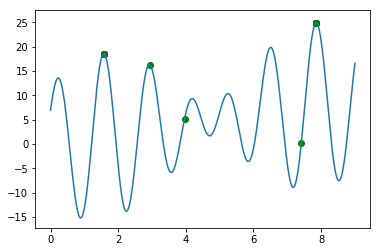

ind_num = 30, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.856746, f(x) = 24.855363
x = 7.856734, f(x) = 24.855363
x = 7.856504, f(x) = 24.855352
x = 7.879741, f(x) = 24.759787
x = 7.777811, f(x) = 23.738878
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.575681, f(x) = 18.571362
x = 1.596846, f(x) = 18.474172
x = 5.209529, f(x) = 10.294545
x = 4.224885, f(x) = 9.255639
x = 4.309350, f(x) = 8.319062
x = 8.865198, f(x) = 7.901566
x = 6.054780, f(x) = 1.236190
x = 1.220097, f(x) = 0.573687
x = 8.725358, f(x) = -1.34539

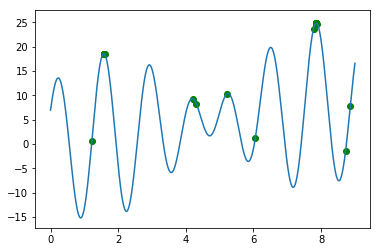

ind_num = 30, iter_num = 1500, crossover_ratio = 0.90, mutation_ratio = 0.30
x = 7.856593, f(x) = 24.855359
x = 7.856985, f(x) = 24.855352
x = 7.856452, f(x) = 24.855347
x = 7.857470, f(x) = 24.855268
x = 7.854667, f(x) = 24.854582
x = 7.853603, f(x) = 24.853577
x = 7.842734, f(x) = 24.819843
x = 7.875648, f(x) = 24.790756
x = 7.890494, f(x) = 24.649790
x = 1.580376, f(x) = 18.563769
x = 1.556958, f(x) = 18.522310
x = 1.556219, f(x) = 18.517769
x = 1.641491, f(x) = 17.745228
x = 1.651473, f(x) = 17.487521
x = 8.076189, f(x) = 16.925739
x = 2.858544, f(x) = 15.710516
x = 2.992197, f(x) = 15.573325
x = 2.788023, f(x) = 13.685671
x = 0.251418, f(x) = 13.512027
x = 0.164640, f(x) = 13.034009
x = 1.301519, f(x) = 6.843970
x = 4.797662, f(x) = 2.289637
x = 4.717782, f(x) = 1.719789
x = 8.741102, f(x) = -0.420041
x = 5.881106, f(x) = -3.430698
x = 8.374616, f(x) = -3.638462
x = 8.596861, f(x) = -6.705990
x = 8.557981, f(x) = -7.366799
x = 7.175297, f(x) = -8.881191
x = 2.328350, f(x) = -12.61

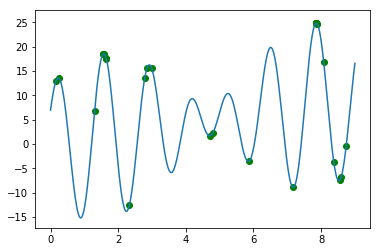

ind_num = 30, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.01
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573559, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573560, f(x) = 18.572178
x = 1.573566, f(x) = 18.572178
x = 7.582264, f(x) = 12.945270
x = 4.212504, f(x) = 9.310398
x = 7.527819, f(x) = 8.76

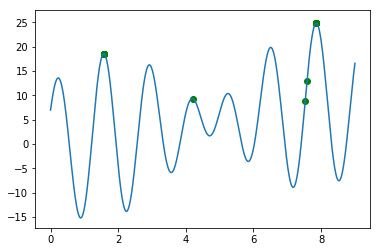

ind_num = 30, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.10
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.832469, f(x) = 24.748778
x = 7.698479, f(x) = 20.514047
x = 1.572476, f(x) = 18.571965
x = 1.571362, f(x) = 18.571304
x = 1.571291, f(x) = 18.571247
x = 1.570629, f(x) = 18.570624
x = 1.570626, f(x) = 18.570621
x = 1.570005, f(x) = 18.569892
x = 1.569973, f(x) = 18.569850
x = 1.569741, f(x) = 18.569539
x = 1.591938, f(x) = 18.511102
x = 1.553945, f(x) = 18.502572
x = 1.546785, f(x) = 18.442544
x = 5.141194, f(x) = 9.557207
x = 4.256840, f(x) = 9.010691
x = 4.086654, f(x) = 8.465515
x = 3.218663, f(x) = 6.129823
x = 4.648436, f(x) = 1.927548
x = 3.374230, f(x) = -1.624721
x = 7.365777, f(x) = -2.888550
x = 5.889642, f(x) = -3.35655

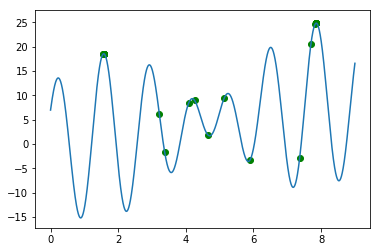

ind_num = 30, iter_num = 1500, crossover_ratio = 0.99, mutation_ratio = 0.30
x = 7.856744, f(x) = 24.855363
x = 7.856743, f(x) = 24.855363
x = 7.856778, f(x) = 24.855363
x = 7.856604, f(x) = 24.855359
x = 7.856528, f(x) = 24.855354
x = 7.856436, f(x) = 24.855346
x = 7.853134, f(x) = 24.853004
x = 7.837292, f(x) = 24.786901
x = 7.826569, f(x) = 24.690743
x = 7.813937, f(x) = 24.524551
x = 7.952782, f(x) = 23.217653
x = 7.997572, f(x) = 21.405907
x = 1.586179, f(x) = 18.543369
x = 1.615108, f(x) = 18.261001
x = 1.620970, f(x) = 18.167442
x = 1.622211, f(x) = 18.146082
x = 1.462159, f(x) = 16.372242
x = 0.206432, f(x) = 13.536679
x = 0.066110, f(x) = 10.068414
x = 5.343317, f(x) = 9.636715
x = 4.302013, f(x) = 8.434868
x = 4.355794, f(x) = 7.469108
x = 6.167566, f(x) = 6.967896
x = 5.539902, f(x) = 4.075862
x = 3.802868, f(x) = -0.711538
x = 7.375208, f(x) = -2.319918
x = 5.798004, f(x) = -3.294196
x = 1.992510, f(x) = -3.940281
x = 3.697235, f(x) = -4.103306
x = 3.629518, f(x) = -5.43000

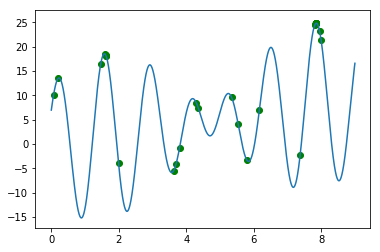

In [249]:
ind_nums = [5, 10, 30]
iter_nums = [500, 1000, 1500]
crossover_ratios = [.7, .9, .99]
mutation_ratios = [.01, .1, .3]

best_params={}
best_fitness = -18

for idn in ind_nums:
    for itn in iter_nums:
        for cr in crossover_ratios:
            for mr in mutation_ratios:
                print("ind_num = %d, iter_num = %d, crossover_ratio = %.2f, mutation_ratio = %.2f" %(idn,itn,cr,mr))
                pop = evolve(idn, itn, cr, mr)
                for ind in pop:
                    print("x = %f, f(x) = %f"%(ind.x,ind.fitness))
                x = np.linspace(0, 9, 10000)
                y = fitness(x)
                scatter_x = np.array([ind.x for ind in pop])
                scatter_y = np.array([ind.fitness for ind in pop])
                plt.plot(x, y)
                plt.scatter(scatter_x, scatter_y, c='g')
                plt.show()
                if(pop[0].fitness>best_fitness):
                    best_pop = pop
                    best_fitness = pop[0].fitness
                    best_params['ind_num'] = idn
                    best_params['iter_num'] = itn
                    best_params['crossover_ratio'] = cr
                    best_params['mutation_ratio'] = mr

best fitness = 24.855363
best params :
ind_num = 30, iter_num = 500, crossover_ratio = 0.90, mutation_ratio = 0.10
best pop :
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856744, f(x) = 24.855363
x = 7.856681, f(x) = 24.855362
x = 7.856634, f(x) = 24.855361
x = 6.576840, f(x) = 19.225599
x = 1.575395, f(x) = 18.571568
x = 1.575506, f(x) = 18.571491
x = 1.575981, f(x) = 18.571116
x = 1.576771, f(x) = 18.570311
x = 1.576895, f(x) = 18.570163
x = 1.576989, f(x) = 18.570049
x = 1.536590, f(x) = 18.325262
x = 1.642661, f(x) = 17.716790
x = 1.675204, f(x) = 16.741626
x = 1.677088, f(x) = 16.674571
x = 2.873495, f(x) = 15.955636
x = 1.695922, f(x) = 15.943261
x = 2.872079, f(x) = 15.935257
x = 4.175564, f(x) = 9.331631
x = 4.259436, f(x) = 8.984547
x = 4.118880, f(x) = 8.930527
x = 4.286871, f(x) = 8.655242
x = 5.631878, f(x) = 0.761788
x = 6.002745, f(x) = -0.816791
x = 8.36348

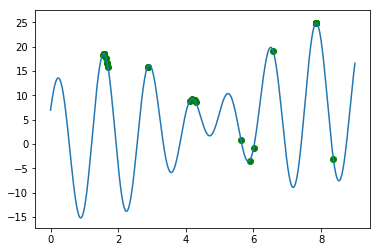

In [250]:
print("best fitness = %f" %best_fitness)
print("best params :")
print("ind_num = %d, iter_num = %d, crossover_ratio = %.2f, mutation_ratio = %.2f" 
      %(best_params['ind_num'],best_params['iter_num'],best_params['crossover_ratio'],best_params['mutation_ratio']))
print("best pop :")
for ind in best_pop:
    print("x = %f, f(x) = %f"%(ind.x,ind.fitness))
    
x = np.linspace(0, 9, 10000)
y = fitness(x)
scatter_x = np.array([ind.x for ind in best_pop])
scatter_y = np.array([ind.fitness for ind in best_pop])
plt.plot(x, y)
plt.scatter(scatter_x, scatter_y, c='g')
plt.show()